# 클러스터링

### 목적: 책들을 유사한 그룹으로 묶기
### 방법: K-means, DBSCAN 같은 클러스터링 알고리즘 사용
### tags, genre, author, series_count와 같은 특징들을 사용하여 유사한 책끼리 그룹화

클러스터별 평균 값:
   cluster  series_count    view_count  recommend_count
0        0    185.495618  1.095593e+06     28411.816856
1        1    755.627119  1.840695e+07    638883.610169
2        2    375.867024  4.150277e+06    127734.871199

클러스터 0에 속한 책들:
                    title  series_count  view_count  recommend_count
0        선독점 천조국은 이제 제겁니다            95     1035408            31429
2  선독점 회귀한 복학생이 건축 명문대 만듦           187     1038449            28943
3                선독점 역천무림           162     1163881            27819
4   선독점 고아출신 포수가 매의 눈을 가짐           112      544534            14732
5   선독점 삼국지 원씨천하 : 무신 원희전           104      842030            18999

클러스터 2에 속한 책들:
                   title  series_count  view_count  recommend_count
1       선독점 아포칼립스에 집을 숨김           520     7033600           392241
6          선독점 로또부터 장군까지           557     2341181            61080
35      선독점 공작님, 회개해주세요!          1509     3552376           259165
39         선독점 재벌집 만렙 아들           484     433

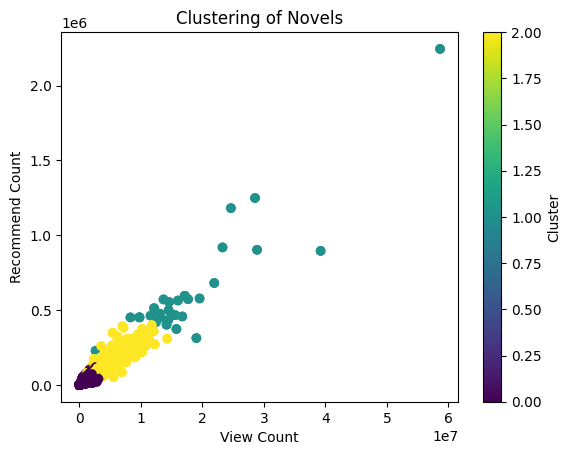

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 필요 없는 열 제거
df_clustering = df[['series_count', 'view_count', 'recommend_count']]

# 스케일링 (데이터 표준화)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

# K-means 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df_scaled)

# 각 클러스터별 평균 값 계산
cluster_summary = df.groupby('cluster').agg({
    'series_count': 'mean',
    'view_count': 'mean',
    'recommend_count': 'mean'
}).reset_index()

print("클러스터별 평균 값:")
print(cluster_summary)

# 각 클러스터에 속한 대표적인 책 5개 출력
for cluster_id in df['cluster'].unique():
    print(f"\n클러스터 {cluster_id}에 속한 책들:")
    cluster_books = df[df['cluster'] == cluster_id].head(5)  # 클러스터별 상위 5개 책 출력
    print(cluster_books[['title', 'series_count', 'view_count', 'recommend_count']])

# 클러스터링 결과 시각화
plt.scatter(df['view_count'], df['recommend_count'], c=df['cluster'], cmap='viridis')
plt.xlabel('View Count')
plt.ylabel('Recommend Count')
plt.title('Clustering of Novels')
plt.colorbar(label='Cluster')
plt.show()


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
import re

# 데이터 불러오기
df = pd.read_csv('munpia_novel_data.csv')

# 콤마 제거 후 숫자형으로 변환 (view_count와 recommend_count)
df['view_count'] = df['view_count'].replace(',', '', regex=True).astype(int)
df['recommend_count'] = df['recommend_count'].replace(',', '', regex=True).astype(int)

# series_count에서 '회' 제거 후 숫자만 추출
df['series_count'] = df['series_count'].apply(lambda x: re.sub(r'[^0-9]', '', x)).astype(int)

# 범주형 데이터 (author, genre, tags) One-Hot Encoding
categorical_features = ['author', 'genre', 'tags']
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_data = encoder.fit_transform(df[categorical_features])

# 인코딩된 데이터를 데이터프레임으로 변환하여 기존 데이터와 병합
encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_features))
df = pd.concat([df, encoded_categorical_df], axis=1)

# 클러스터링을 위한 스케일링
scaler = StandardScaler()
df_clustering = df[['series_count', 'view_count', 'recommend_count']]
df_scaled = scaler.fit_transform(df_clustering)

# K-means 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df_scaled)

# 클러스터별로 랜덤 포레스트 회귀 모델 적용
for cluster_id in df['cluster'].unique():
    print(f"\n클러스터 {cluster_id}에 대한 랜덤 포레스트 회귀 모델")
    
    # 해당 클러스터 데이터 추출
    cluster_data = df[df['cluster'] == cluster_id]
    
    # 사용할 특징 변수 (series_count, view_count, 범주형 인코딩 데이터 포함)
    X = pd.concat([cluster_data[['series_count', 'view_count']], cluster_data[encoded_categorical_df.columns]], axis=1)
    
    # 타겟 변수 (추천수를 예측)
    y = cluster_data['recommend_count']
    
    # KFold 설정 (5번 교차 검증)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # 결과 저장용 리스트
    train_rmse_list = []
    test_rmse_list = []
    train_r2_list = []
    test_r2_list = []

    # 5번 교차 검증 수행
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold + 1}:")
        
        # 훈련 데이터와 테스트 데이터 분리
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # 랜덤 포레스트 회귀 모델 학습
        model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
        model.fit(X_train, y_train)
        
        # 예측
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # 평가 (Root Mean Squared Error, R² Score)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        # 결과 출력
        print(f'Training RMSE: {train_rmse}, Testing RMSE: {test_rmse}')
        print(f'Training R² Score: {train_r2}, Testing R² Score: {test_r2}')
        
        # 결과 저장
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)
        train_r2_list.append(train_r2)
        test_r2_list.append(test_r2)

    # 클러스터별 평균 결과 출력
    print(f"\n### 클러스터 {cluster_id} 최종 결과 ###")
    print(f'평균 Training RMSE: {np.mean(train_rmse_list)}, 평균 Testing RMSE: {np.mean(test_rmse_list)}')
    print(f'평균 Training R² Score: {np.mean(train_r2_list)}, 평균 Testing R² Score: {np.mean(test_r2_list)}')

    # 마지막 fold에서 추천수가 높을 것 같은 책의 제목 출력
    X_test.loc[:, 'predicted_recommend_count'] = y_test_pred  # 경고 제거
    X_test_with_titles = X_test.join(cluster_data[['title']], how='left')  # 원본 데이터의 제목과 결합
    
    # 추천수가 높을 것 같은 책의 제목 상위 5개 출력
    top_5_books = X_test_with_titles.sort_values(by='predicted_recommend_count', ascending=False).head(5)
    print(f"\n클러스터 {cluster_id}에서 추천수가 높을 것으로 예측된 책의 제목 상위 5개:")
    print(top_5_books[['title', 'predicted_recommend_count']])



클러스터 0에 대한 랜덤 포레스트 회귀 모델

Fold 1:
Training RMSE: 5992.732389799295, Testing RMSE: 7025.865596102462
Training R² Score: 0.9213103106896122, Testing R² Score: 0.8917886833951792

Fold 2:
Training RMSE: 5971.869614623677, Testing RMSE: 6612.3486667183215
Training R² Score: 0.9218617289382446, Testing R² Score: 0.9041939979401914

Fold 3:
Training RMSE: 6023.434535743323, Testing RMSE: 6713.116348493665
Training R² Score: 0.920644572547859, Testing R² Score: 0.9006144231255989

Fold 4:
Training RMSE: 5998.094434029765, Testing RMSE: 7143.801588802373
Training R² Score: 0.9200734764323779, Testing R² Score: 0.8940169863624836

Fold 5:
Training RMSE: 6074.512420643815, Testing RMSE: 6515.859371156331
Training R² Score: 0.920141264094649, Testing R² Score: 0.9020685846556158

### 클러스터 0 최종 결과 ###
평균 Training RMSE: 6012.128678967974, 평균 Testing RMSE: 6802.1983142546305
평균 Training R² Score: 0.9208062705405485, 평균 Testing R² Score: 0.8985365350958137

클러스터 0에서 추천수가 높을 것으로 예측된 책의 제목 상위 5개:
    

C:\Users\신형우\AppData\Local\Temp\ipykernel_20332\2117672509.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, 'predicted_recommend_count'] = y_test_pred  # 경고 제거



Fold 1:
Training RMSE: 15314.799644004877, Testing RMSE: 21741.46771317875
Training R² Score: 0.9456397490483719, Testing R² Score: 0.8908175488534634

Fold 2:
Training RMSE: 15739.556081545365, Testing RMSE: 21720.655049246772
Training R² Score: 0.9427652865564755, Testing R² Score: 0.8898212101114372

Fold 3:
Training RMSE: 16301.291625373062, Testing RMSE: 24925.326159455824
Training R² Score: 0.935706465446249, Testing R² Score: 0.8766205884263897

Fold 4:
Training RMSE: 15848.177015324658, Testing RMSE: 22036.21630664501
Training R² Score: 0.9449284342770267, Testing R² Score: 0.8556052279489311

Fold 5:
Training RMSE: 16133.544072680295, Testing RMSE: 21940.959181841485
Training R² Score: 0.9389948420381008, Testing R² Score: 0.8939277709747395

### 클러스터 2 최종 결과 ###
평균 Training RMSE: 15867.473687785652, 평균 Testing RMSE: 22472.924882073574
평균 Training R² Score: 0.9416069554732449, 평균 Testing R² Score: 0.8813584692629922

클러스터 2에서 추천수가 높을 것으로 예측된 책의 제목 상위 5개:
                     

C:\Users\신형우\AppData\Local\Temp\ipykernel_20332\2117672509.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, 'predicted_recommend_count'] = y_test_pred  # 경고 제거


Training RMSE: 43498.856233321094, Testing RMSE: 78317.9580532319
Training R² Score: 0.9882041937997734, Testing R² Score: 0.9061578129447523

Fold 2:
Training RMSE: 87120.00449576059, Testing RMSE: 169586.28481461862
Training R² Score: 0.9306894271895504, Testing R² Score: 0.890677936391661

Fold 3:
Training RMSE: 46879.769364128595, Testing RMSE: 45120.86171501876
Training R² Score: 0.9866759485840086, Testing R² Score: 0.9600303640196934

Fold 4:
Training RMSE: 42092.23880870845, Testing RMSE: 46105.99211481658
Training R² Score: 0.9894057790532812, Testing R² Score: 0.9332431373594711

Fold 5:
Training RMSE: 58834.28299039294, Testing RMSE: 127818.38919154592
Training R² Score: 0.9676871732545675, Testing R² Score: 0.9395189229174625

### 클러스터 1 최종 결과 ###
평균 Training RMSE: 55685.030378462325, 평균 Testing RMSE: 93389.89717784636
평균 Training R² Score: 0.9725325043762363, 평균 Testing R² Score: 0.9259256347266082

클러스터 1에서 추천수가 높을 것으로 예측된 책의 제목 상위 5개:
               title  predicted_reco

C:\Users\신형우\AppData\Local\Temp\ipykernel_20332\2117672509.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, 'predicted_recommend_count'] = y_test_pred  # 경고 제거


### 1. 클러스터 0:

##### 평균 연재 횟수: 약 185회
##### 평균 조회수: 약 1,095,593회
##### 평균 추천수: 약 28,412회
##### 이 그룹은 상대적으로 연재 횟수와 조회수가 적으며, 추천수도 낮은 소설들이 포함되어 있습니다.

#### 2. 클러스터 1:

##### 평균 연재 횟수: 약 755회
##### 평균 조회수: 약 18,406,950회
##### 평균 추천수: 약 638,884회
##### 이 그룹은 매우 많은 연재 횟수와 높은 조회수, 추천수를 가진 소설들이 포함되어 있습니다. 대중적으로 매우 인기가 많은 소설들입니다.

#### 3. 클러스터 2:

##### 평균 연재 횟수: 약 375회
##### 평균 조회수: 약 4,150,277회
##### 평균 추천수: 약 127,735회
##### 이 그룹은 클러스터 0보다는 조회수와 추천수가 높고, 클러스터 1보다는 적당한 수준의 소설들이 포함되어 있습니다.

# 랜덤포레스트 분석

### 1. 조회수가 높은 소설은 일반적으로 더 많은 추천수를 받을 가능성이 크다.
### 2. 연재 횟수가 많은 소설은 팬층이 두터워질 수 있기 때문에 추천수가 많을 가능성이 높다.
### 3. 특정 장르나 작가는 더 많은 인기를 끌 수 있을 것이다.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import re

# 데이터 불러오기
df = pd.read_csv('munpia_novel_data.csv')

# 콤마 제거 후 숫자형으로 변환 (view_count와 recommend_count)
df['view_count'] = df['view_count'].replace(',', '', regex=True).astype(int)
df['recommend_count'] = df['recommend_count'].replace(',', '', regex=True).astype(int)

# series_count에서 '회' 제거 후 숫자만 추출
df['series_count'] = df['series_count'].apply(lambda x: re.sub(r'[^0-9]', '', x)).astype(int)

# 범주형 데이터 (author, genre, tags) One-Hot Encoding 하나로 합치기.
categorical_features = ['author', 'genre', 'tags']
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_data = encoder.fit_transform(df[categorical_features])

# 인코딩된 데이터를 데이터프레임으로 변환하여 기존 데이터와 병합
encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_features))
df = pd.concat([df, encoded_categorical_df], axis=1)

# 사용할 특징 변수 (series_count, view_count, 범주형 인코딩 데이터 포함)
X = pd.concat([df[['series_count', 'view_count']], encoded_categorical_df], axis=1)

# 타겟 변수 (추천수를 예측)
y = df['recommend_count']

# 학습용/테스트용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 회귀 모델 사용
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 예측
y_train_pred = model.predict(X_train)  # 훈련 데이터 예측
y_test_pred = model.predict(X_test)    # 테스트 데이터 예측

# 평가 (Mean Squared Error, R² Score)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Training MSE: {train_mse}, Testing MSE: {test_mse}')
print(f'Training R² Score: {train_r2}, Testing R² Score: {test_r2},  Testing R² Score: {test_r2},  Testing R² Score: {test_r2},  Testing R² Score: {test_r2}')

# 예측된 추천수와 실제 데이터를 결합하여 추천수가 높을 것 같은 책의 제목 출력
X_test['predicted_recommend_count'] = y_test_pred  # 예측값을 테스트 데이터에 추가
X_test_with_titles = X_test.join(df[['title']], how='left')  # 원본 데이터의 제목과 결합

# 추천수가 높을 것 같은 책의 제목 상위 5개 출력
top_5_books = X_test_with_titles.sort_values(by='predicted_recommend_count', ascending=False).head(5)
print("추천수가 높을 것으로 예측된 책의 제목 상위 5개:")
print(top_5_books[['title', 'predicted_recommend_count']])


Training MSE: 13440695.139375256, Testing MSE: 41738202.13075601
Training R² Score: 0.9967078275352447, Testing R² Score: 0.9896545778535005,  Testing R² Score: 0.9896545778535005,  Testing R² Score: 0.9896545778535005,  Testing R² Score: 0.9896545778535005
추천수가 높을 것으로 예측된 책의 제목 상위 5개:
                   title  predicted_recommend_count
2054   선독점 백작가의 망나니가 되었다                 1161105.14
2455       선독점 내가 키운 S급들                 1088607.96
12910       선독점 재벌집 막내아들                  955189.01
36         선독점 약먹는 천재마법사                  937146.10
6393       선독점 소설 속 엑스트라                  726284.02


#### 위는 잘 팔릴 것 같은 소설 목록을 뽑아본 것

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import re

# 데이터 불러오기
df = pd.read_csv('munpia_novel_data.csv')

# 콤마 제거 후 숫자형으로 변환 (view_count와 recommend_count)
df['view_count'] = df['view_count'].replace(',', '', regex=True).astype(int)
df['recommend_count'] = df['recommend_count'].replace(',', '', regex=True).astype(int)

# series_count에서 '회' 제거 후 숫자만 추출
df['series_count'] = df['series_count'].apply(lambda x: re.sub(r'[^0-9]', '', x)).astype(int)

# 범주형 데이터 (author, genre, tags) One-Hot Encoding
categorical_features = ['author', 'genre', 'tags']
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_data = encoder.fit_transform(df[categorical_features])

# 인코딩된 데이터를 데이터프레임으로 변환하여 기존 데이터와 병합
encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_features))
df = pd.concat([df, encoded_categorical_df], axis=1)

# 사용할 특징 변수 (series_count, view_count, 범주형 인코딩 데이터 포함)
X = pd.concat([df[['series_count', 'view_count']], encoded_categorical_df], axis=1)

# 타겟 변수 (추천수를 예측)
y = df['recommend_count']

# KFold 설정 (5번 교차 검증)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 결과 저장용 리스트
train_mse_list = []
test_mse_list = []
train_r2_list = []
test_r2_list = []

# 5번 교차 검증 수행
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}:")
    
    # 훈련 데이터와 테스트 데이터 분리
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 랜덤 포레스트 회귀 모델 학습
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    
    # 예측
    y_train_pred = model.predict(X_train)  # 훈련 데이터 예측
    y_test_pred = model.predict(X_test)    # 테스트 데이터 예측
    
    # 평가 (Mean Squared Error, R² Score)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # 결과 출력
    print(f'Training MSE: {train_mse}, Testing MSE: {test_mse}')
    print(f'Training R² Score: {train_r2}, Testing R² Score: {test_r2}')
    
    # 결과 저장
    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

# 평균 결과 출력
print("\n### 최종 결과 ###")
print(f'평균 Training MSE: {np.mean(train_mse_list)}, 평균 Testing MSE: {np.mean(test_mse_list)}')
print(f'평균 Training R² Score: {np.mean(train_r2_list)}, 평균 Testing R² Score: {np.mean(test_r2_list)}')

# 마지막 fold에서 추천수가 높을 것 같은 책의 제목 출력
X_test['predicted_recommend_count'] = y_test_pred  # 예측값을 테스트 데이터에 추가
X_test_with_titles = X_test.join(df[['title']], how='left')  # 원본 데이터의 제목과 결합

# 추천수가 높을 것 같은 책의 제목 상위 5개 출력
top_5_books = X_test_with_titles.sort_values(by='predicted_recommend_count', ascending=False).head(5)
print("\n추천수가 높을 것으로 예측된 책의 제목 상위 5개:")
print(top_5_books[['title', 'predicted_recommend_count']])



Fold 1:
Training MSE: 16300870.25534236, Testing MSE: 42446133.41519139
Training R² Score: 0.9960072544128338, Testing R² Score: 0.9894791067595312

Fold 2:
Training MSE: 33188332.4169147, Testing MSE: 157646577.20375586
Training R² Score: 0.9912340928768085, Testing R² Score: 0.9697854625558067

Fold 3:
Training MSE: 22396728.948901426, Testing MSE: 69953657.83186243
Training R² Score: 0.9947859846751133, Testing R² Score: 0.9780219262955347

Fold 4:
Training MSE: 29815413.29015217, Testing MSE: 169068081.06276816
Training R² Score: 0.9922697010656719, Testing R² Score: 0.965755153942202

Fold 5:
Training MSE: 17472628.706416484, Testing MSE: 62803942.112315476
Training R² Score: 0.9959772254525496, Testing R² Score: 0.9789656203075017

### 최종 결과 ###
평균 Training MSE: 23834794.723545432, 평균 Testing MSE: 100383678.32517865
평균 Training R² Score: 0.9940548516965955, 평균 Testing R² Score: 0.9764014539721153


C:\Users\신형우\AppData\Local\Temp\ipykernel_10620\2625232625.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['predicted_recommend_count'] = y_test_pred  # 예측값을 테스트 데이터에 추가



추천수가 높을 것으로 예측된 책의 제목 상위 5개:
                   title  predicted_recommend_count
281    선독점 백작가의 망나니가 되었다                 1107318.26
559          선독점 탑 매니지먼트                  532759.28
11138   선독점 방랑기사로 살아가는 법                  519564.08
78      선독점 회귀수선전(回歸修仙傳)                  517306.23
1798    선독점 러스트 [ RUST ]                  470763.33


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import re

# 데이터 불러오기
df = pd.read_csv('munpia_novel_data.csv')

# 콤마 제거 후 숫자형으로 변환 (view_count와 recommend_count)
df['view_count'] = df['view_count'].replace(',', '', regex=True).astype(int)
df['recommend_count'] = df['recommend_count'].replace(',', '', regex=True).astype(int)

# series_count에서 '회' 제거 후 숫자만 추출
df['series_count'] = df['series_count'].apply(lambda x: re.sub(r'[^0-9]', '', x)).astype(int)

# 범주형 데이터 (author, genre, tags) One-Hot Encoding
categorical_features = ['author', 'genre', 'tags']
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_data = encoder.fit_transform(df[categorical_features])

# 인코딩된 데이터를 데이터프레임으로 변환하여 기존 데이터와 병합
encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_features))
df = pd.concat([df, encoded_categorical_df], axis=1)

# 사용할 특징 변수 (series_count, view_count, 범주형 인코딩 데이터 포함)
X = pd.concat([df[['series_count', 'view_count']], encoded_categorical_df], axis=1)

# 타겟 변수 (추천수를 예측)
y = df['recommend_count']

# KFold 설정 (5번 교차 검증)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 결과 저장용 리스트
train_rmse_list = []
test_rmse_list = []
train_r2_list = []
test_r2_list = []

# 5번 교차 검증 수행
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}:")
    
    # 훈련 데이터와 테스트 데이터 분리
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 랜덤 포레스트 회귀 모델 학습 (모델 복잡성 줄이기 위해 max_depth 제한)
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    model.fit(X_train, y_train)
    
    # 예측
    y_train_pred = model.predict(X_train)  # 훈련 데이터 예측
    y_test_pred = model.predict(X_test)    # 테스트 데이터 예측
    
    # 평가 (Root Mean Squared Error, R² Score)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # 결과 출력
    print(f'Training RMSE: {train_rmse}, Testing RMSE: {test_rmse}')
    print(f'Training R² Score: {train_r2}, Testing R² Score: {test_r2}')
    
    # 결과 저장
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

# 평균 결과 출력
print("\n### 최종 결과 ###")
print(f'평균 Training RMSE: {np.mean(train_rmse_list)}, 평균 Testing RMSE: {np.mean(test_rmse_list)}')
print(f'평균 Training R² Score: {np.mean(train_r2_list)}, 평균 Testing R² Score: {np.mean(test_r2_list)}')

# 마지막 fold에서 추천수가 높을 것 같은 책의 제목 출력
X_test.loc[:, 'predicted_recommend_count'] = y_test_pred  # .loc을 사용해 경고 제거
X_test_with_titles = X_test.join(df[['title']], how='left')  # 원본 데이터의 제목과 결합

# 추천수가 높을 것 같은 책의 제목 상위 5개 출력
top_5_books = X_test_with_titles.sort_values(by='predicted_recommend_count', ascending=False).head(5)
print("\n추천수가 높을 것으로 예측된 책의 제목 상위 5개:")
print(top_5_books[['title', 'predicted_recommend_count']])



Fold 1:
Training RMSE: 9759.593388258592, Testing RMSE: 10997.949786980465
Training R² Score: 0.9766694865929944, Testing R² Score: 0.9700195640370403

Fold 2:
Training RMSE: 10480.723175982701, Testing RMSE: 15382.509850946837
Training R² Score: 0.9709869134193568, Testing R² Score: 0.9546491106781403

Fold 3:
Training RMSE: 9779.821632256084, Testing RMSE: 12005.224743855086
Training R² Score: 0.9777336220094058, Testing R² Score: 0.9547186061900347

Fold 4:
Training RMSE: 10264.66368103839, Testing RMSE: 15454.810769712074
Training R² Score: 0.9726822514202691, Testing R² Score: 0.9516205442272201

Fold 5:
Training RMSE: 9646.177213781193, Testing RMSE: 11050.864064537835
Training R² Score: 0.9785771169023907, Testing R² Score: 0.9590988727049248

### 최종 결과 ###
평균 Training RMSE: 9986.195818263392, 평균 Testing RMSE: 12978.27184320646
평균 Training R² Score: 0.9753298780688834, 평균 Testing R² Score: 0.9580213395674722


C:\Users\신형우\AppData\Local\Temp\ipykernel_10620\2396310769.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, 'predicted_recommend_count'] = y_test_pred  # .loc을 사용해 경고 제거



추천수가 높을 것으로 예측된 책의 제목 상위 5개:
                   title  predicted_recommend_count
281    선독점 백작가의 망나니가 되었다               1.134940e+06
559          선독점 탑 매니지먼트               5.313117e+05
11138   선독점 방랑기사로 살아가는 법               5.243189e+05
78      선독점 회귀수선전(回歸修仙傳)               5.233992e+05
1798    선독점 러스트 [ RUST ]               4.673246e+05
